## Bring in libraries and credentials

In [1]:
import datetime
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
%matplotlib inline

## Read the raw data

In [2]:
AllData=pd.read_csv('K:\Rainshelter\Oats 2017-2018\LoggedData\RainShelterAlpha_CS650.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

## Apply indexing 

In [3]:
#Bring in index data
AllDataIndex=pd.read_csv('K:\Rainshelter\Oats 2017-2018\LoggedData\SoilWaterAndTempIndex.csv',
                         index_col = 0)
#Apply indexes to data
AllDataTransposed = AllData.transpose()
AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1)
AllDataIndexed.index.name='ColumnHeader'
AllDataIndexed.set_index(['Measurement','Depth','Nitrogen','Irrigation','Plot','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
                        append=False, inplace=True)
AllDataIndexed.sort_index(inplace=True)
FieldData=AllDataIndexed.transpose()
FieldData.index = FieldData.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back


## Calculate

In [4]:
%matplotlib inline
#Calculate treatment means 
DataMeans =  FieldData.groupby(level=['Measurement','Depth','Irrigation', 'Nitrogen'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function
#DataMeans = DataMeans.resample('4H').last()

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D1I'] * 150/2 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D1B'] * 150/2 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D2'] * 150 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D3'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D4'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D5'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D6'] * 300 + \
               DataMeans.VolumetricWaterContent.where(DataMeans.VolumetricWaterContent<1).ix[:,'D7'] * 300

FieldCapacity = ProfileWater.resample('D').max()
FieldCapacity = FieldCapacity.loc['2017-08-28'] 
SoilWaterDeficit = -(FieldCapacity - ProfileWater)

In [5]:
SoilWaterDeficit.index.max()

Timestamp('2018-01-25 07:15:00')

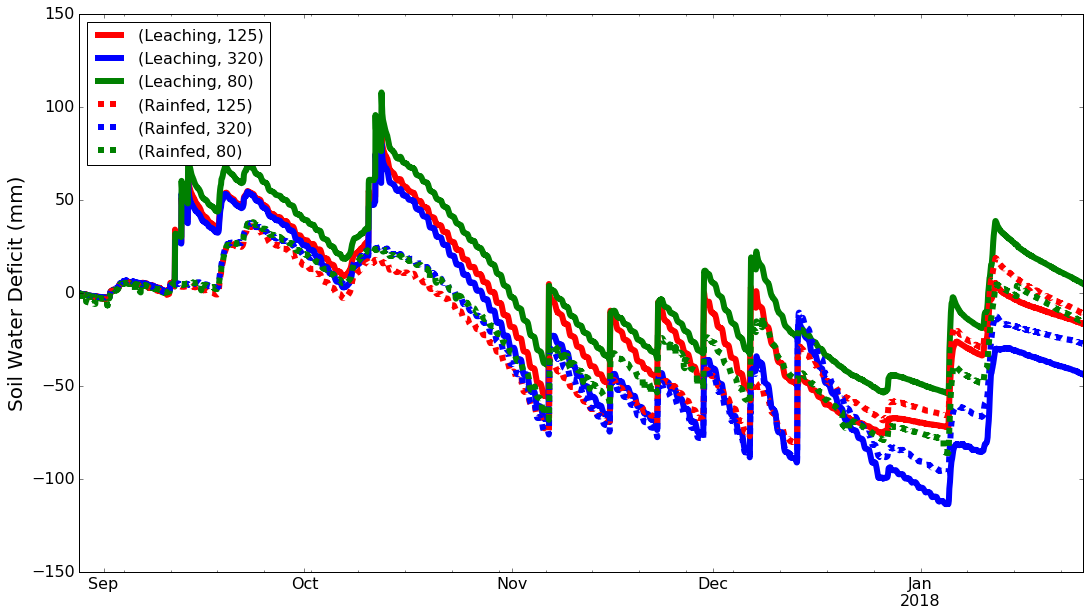

In [6]:
SoilWaterDeficit.ix[::].plot(figsize=(18,10),linewidth=6,style=['r-','b-','g-','r--','b--','g--'])
plt.tick_params(labelsize=16)
plt.ylabel('Soil Water Deficit (mm)',fontsize=20)
plt.legend(loc=2,fontsize=16)

In [7]:
GraphData = DataMeans.VolumetricWaterContent.copy()
for irr in ['Rainfed','Leaching']:
    for N in ['80','125','320']:
        GraphData.ix[:,('D1',irr,N)] = (GraphData.ix[:,('D1B',irr,N)]+GraphData.ix[:,('D1I',irr,N)])/2
GraphData.drop(['D1B','D1I'],axis=1,inplace=True)
GraphData.sort_index(axis=1,inplace=True)

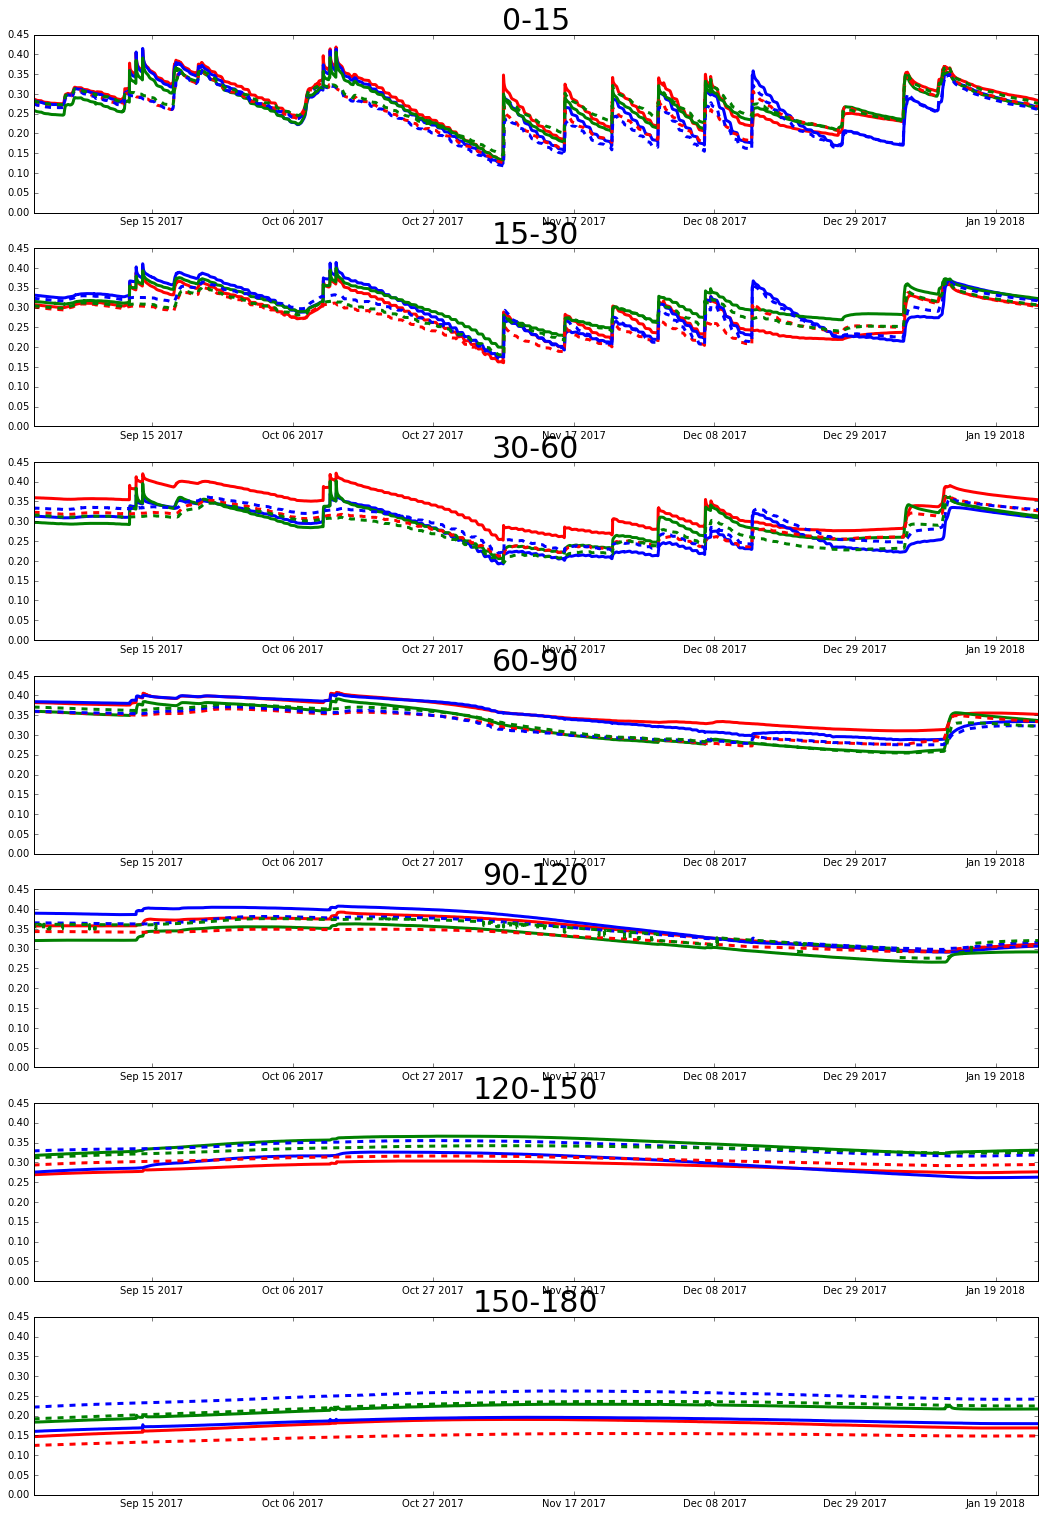

In [8]:
Depths = ['D1','D2','D3','D4','D5','D6','D7']
labels = ['0-15','15-30','30-60','60-90','90-120','120-150','150-180']
from cycler import cycler
graph = plt.figure(figsize=(18,30))

pos=1
for Depth in Depths:
    ax = graph.add_subplot(8,1,pos)
    ax.set_prop_cycle(cycler('color',['r','b','g','r','b','g']) +
                     cycler('linestyle',['-','-','-','--','--','--']))
    DepthData = GraphData.where(GraphData<1).ix[:,Depth]
    plt.plot(DepthData,linewidth = 3)
    plt.title(labels[pos-1],fontsize=30)
    plt.ylim(0,0.45)
    pos+=1

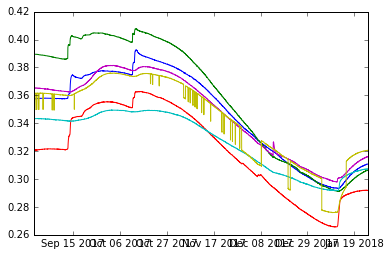

In [9]:
Data = GraphData.where(GraphData<1).ix[:,'D5']
for plot in Data:
    plt.plot(Data.ix[:,plot])
    #plt.legend()

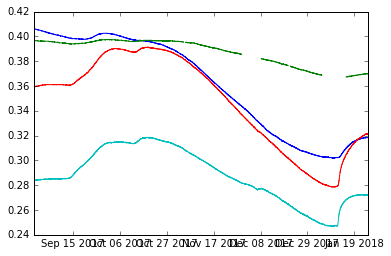

In [10]:
PlotData = FieldData.ix[:,('VolumetricWaterContent','D5','80','Rainfed')]
for plot in PlotData:
    plt.plot(PlotData.ix[:,plot])
    #plt.legend(loc=0)